In [2]:
from typing import Tuple, Dict, Callable, Iterator, Union, Optional, List

import os
import sys
from datetime import date

import numpy as np
import scipy

import torch
import botorch
import gpytorch

import gym
import gym_lqr

# To import module code.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.environment_api import EnvironmentObjective, StateNormalizer
from src.policy_parameterizations import MLP, discretize
from src.loop import loop
from src.optimizers import BayesianGradientAscent
from src.model import DerivativeExactGPSEModel
from src.acquisition_function import optimize_acqf_custom_bo

import matplotlib.pyplot as plt
%config Completer.use_jedi = False

# Run experiments

In [3]:
env = gym.make('lqr-v0')
mlp = MLP(3,3)
len_params = mlp.len_params

[2021-11-24 20:14:50,127] Making new env: lqr-v0
/home/sarah/miniconda3/envs/bga/lib/python3.8/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [4]:
objective_env = EnvironmentObjective(env=env, 
                                     policy=mlp, 
                                     manipulate_state=None, 
                                     manipulate_reward=lambda r, a, s, d: - torch.log(1-r))

In [ ]:
# Third Optimizer: Custom BO 
parameters = {}
calls = {}
for trial in range(100):
    print(f'trail {trial+1}')
    params, calls_in_iteration = loop(params_init=torch.zeros(1,9),
                                      max_iterations=None,
                                      max_objective_calls=130,
                                      objective=objective_env,
                                      Optimizer=BayesianGradientAscent,
                                      optimizer_config={'max_samples_per_iteration': 9,
                                                        'OptimizerTorch': torch.optim.SGD,
                                                        'optimizer_torch_config': {'lr': 1.},
                                                        'lr_schedular': {0: 0.15, 3: 0.1, 8: 0.05}, #{0: 0.25, 3: 0.1, 6: 0.05},
                                                        'Model': DerivativeExactGPSEModel,
                                                        'model_config': {'prior_mean': torch.tensor(0., dtype=torch.float32),
                                                                         'ard_num_dims': len_params,
                                                                         'N_max': 40,
                                                                         'lengthscale_constraint': None,
                                                                         'lengthscale_hyperprior': gpytorch.priors.UniformPrior(.01, 0.3),
                                                                         'outputscale_constraint': None,
                                                                         'outputscale_hyperprior': gpytorch.priors.NormalPrior(20, 5),
                                                                         'noise_constraint': None, 
                                                                         'noise_hyperprior': gpytorch.priors.NormalPrior(2,1)},
                                                        'hyperparameter_config': {'optimize_hyperparameters': True,
                                                                                  'hypers': {#'covar_module.base_kernel.lengthscale': torch.tensor(.1),
                                                                                             #'covar_module.outputscale': torch.tensor(10.),
                                                                                             'likelihood.noise': torch.tensor(2.)},
                                                                                  'no_noise_optimization': True}, 
                                                        'optimize_acqf': optimize_acqf_custom_bo, 
                                                        'optimize_acqf_config': {'q': 1,
                                                                                 'num_restarts': 5,
                                                                                 'raw_samples': 64},
                                                        'bounds': None,
                                                        'delta': 0.1,
                                                        'epsilon_diff_acq_value': None,
                                                        'generate_initial_data': None,
                                                        'standard_deviation_scaling': False,
                                                        'normalize_gradient': True,
                                                        'verbose': False,
                                                       },
                                      verbose=True)
    parameters[trial] = torch.cat(params)
    calls[trial] = calls_in_iteration

In [259]:
# Save data
path_to_experiments = os.path.join('./experiments/lqr/', date.today().strftime("%m%d%Y"))
torch.save(parameters, os.path.join(path_to_experiments, 'parameters.pt'))
torch.save(calls, os.path.join(path_to_experiments, 'calls.pt'))

## Analyze results

In [5]:
# Load data
path_to_experiments = '../experiments/lqr/10152021/'
parameters = torch.load(path_to_experiments + 'parameters.pt')
calls = torch.load(path_to_experiments + 'calls.pt')

In [6]:
def dlqr(A,B,Q,R):
    """Solve the discrete time lqr controller.

    x[k+1] = A x[k] + B u[k]

    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    """
    # Solves the discrete-time algebraic Riccati equation (DARE).
    P = scipy.linalg.solve_discrete_are(A, B, Q, R)

    # Compute the LQR gain
    K = - np.linalg.inv(R + B.T @ P @ B) @ (B.T @ P @ A)

    eigVals, _ = np.linalg.eig(A + B @ K)

    return K, P, eigVals

In [7]:
def stability_analysis(parameters: Dict[int, torch.tensor], 
                       A: np.array,
                       B: np.array) -> Dict[int, torch.tensor]:
    stability = {}
    for i, params in parameters.items():
        stability_params = torch.zeros(len(calls[i])+1)
        for j, param in enumerate(params):
            eigVals, _ = np.linalg.eig(A + B @ param.view(3,3).numpy())
            if max(np.absolute(eigVals)) < 1:
                stability_params[j] = 1
        stability[i] = stability_params
    return stability

In [8]:
def postprocessing_interpolate_x(x: Dict[int, torch.tensor], 
                                 calls: Dict[int, List], 
                                 max_calls: int):
    runs = list(x.keys())
    interpolation = torch.empty((len(runs), max_calls))
    for index_run, run in enumerate(runs):
        index_x = 0
        for num_call in range(max_calls):
            if num_call == calls[index_run][index_x]:
                index_x += 1
            interpolation[index_run][num_call] = x[index_run][index_x]
    return interpolation

In [9]:
def get_relative_costs(parameters: Dict[int, torch.tensor],
                       stabiltiy: Dict[int, torch.tensor],
                       A: np.array,
                       B: np.array,
                       W: np.array,
                       R: np.array,
                       P: np.array):
    relative_costs = {}
    for i, params in parameters.items():
        relative_cost = torch.empty(params.shape[0])
        for j, param in enumerate(params):
            if stability[i][j] == 1:
                K_hat = param.view(3,3).numpy()
                sigma_param_hat = scipy.linalg.solve_discrete_lyapunov((A + B @ K_hat), W)
                r_c = np.trace(sigma_param_hat @ (K_hat - K).T @ (R + B.T @ P @ B) @ (K_hat - K)) / np.trace(W @ P)
                relative_cost[j] = r_c
            else:
                relative_cost[j] = np.nan
        relative_costs[i] = relative_cost
    return relative_costs

In [10]:
plt.style.use('seaborn-whitegrid')
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 9,
    "font.size": 9,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [11]:
def plot_frequency_of_stability(interpolated_stability, path_savefig: Optional = None):
    fig = plt.figure(figsize=(2.2, 1.2))
    plt.plot(torch.linspace(0,40000,13), 
             torch.mean(interpolate_stability[:, ::10], axis=0), 
             marker='>', markersize=3, linestyle='dashed', label='GIBO',markevery=2)
    plt.plot(10000, 1,'o', color='black', label='LSPI', markersize=2,markevery=50)
    plt.plot(29000, 1,'x', color='red', label='ARS', markersize=3,markevery=50)
    plt.xlabel('Number Timesteps')
    plt.ylabel(r'Fequency Stability')
    plt.xticks(np.arange(0, 40001, 10000))
    plt.yticks(np.arange(0,1.1,0.2))
    plt.xlim(-2000, 42000)
    plt.grid(linestyle='dotted')
    plt.legend(frameon=False)
    if path_savefig:
        plt.savefig(path_savefig, bbox_inches='tight')
    return fig

In [12]:
def plot_relative_cost(interpolate_costs, path_savefig: Optional = None):
    fig = plt.figure(figsize=(2.2, 1.2))
    median = np.nanmedian(interpolate_costs.numpy(), axis=0)[::10]
    p_lower = np.nanpercentile(interpolate_costs.numpy(), q=2, axis=0)[::10]
    p_upper = np.nanpercentile(interpolate_costs.numpy(), q=98, axis=0)[::10]
    plt.plot(torch.linspace(0,40000,13), median, 
             marker='>', markersize=3, linestyle='dashed', label='GIBO', markevery=2)
    plt.fill_between(torch.linspace(0,40000,13), p_lower, p_upper, alpha=0.3)
    plt.plot(40000, 8*10**(-2),'bo', color='black', label='LSPI', markersize=2, markevery=50)
    plt.plot(40000, 6*10**(-2),'rx', color='red', label='ARS', markersize=3, markevery=50)
    plt.yscale('log')
    plt.ylim(10e-3, 10)
    plt.xlim(0, 42000)
    plt.xlabel('Number Timesteps')
    plt.ylabel('Relative Cost')
    plt.xticks(range(0, 40001, 10000))
    plt.grid(linestyle='dotted')
    #plt.legend(frameon=False)
    if path_savefig:
        plt.savefig(path_savefig, bbox_inches='tight')
    return fig

In [13]:
env = gym.make('lqr-v0')
A, B, Q, R = env.get_params()
K, P, eigVals = dlqr(A, B, Q, R)
W = np.eye(3)

[2021-11-24 20:15:00,321] Making new env: lqr-v0
/home/sarah/miniconda3/envs/bga/lib/python3.8/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [14]:
stability = stability_analysis(parameters, A, B)

In [15]:
interpolate_stability = postprocessing_interpolate_x(stability,
                                                     calls,
                                                     max_calls=130)

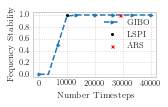

In [16]:
plot_frequency_of_stability(interpolate_stability, 
                            path_savefig = None); #'../experiments/lqr/10152021/lqr_frequency_stability.pdf'

In [17]:
relative_costs = get_relative_costs(parameters, stability, A, B, W, R, P)

In [18]:
interpolate_costs = postprocessing_interpolate_x(relative_costs, calls, max_calls=130)

/home/sarah/miniconda3/envs/bga/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/sarah/miniconda3/envs/bga/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


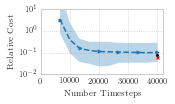

In [20]:
plot_relative_cost(interpolate_costs, 
                   path_savefig=None); #'../experiments/lqr/10152021/lqr_relative_error.pdf'